# Digit recognization model
 
This model will be trained on the MNIST handwritten digits dataset (This notebook uses the CNN method)
* tensorflow is our general purpose ml library with all the utlities we need
* numpy has all our various data types like arrays, matrices etc.
* matplotlib for plotting and visualising the numpy array of values

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import random

**Library diagnostic information**

In [4]:
print('Numpy ' + np.__version__)
print('Tensorflow ' + tf.__version__)

Numpy 1.26.2
Tensorflow 2.15.0


**Model Parameters**

In [5]:
tflite_model_name = 'digit_recognize_28'

**Load the dataset from tensorflow datasets**

* X is the list of input image array (input data is uint8)
* Y list of the digit the input image corresponds to (digits 0 - 9)

the data is already pre divided into train and test datasets

In [6]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [7]:
print('Number of total samples: ', len(X_train) + len(X_test))
print('Number of train samples: ', len(X_train))
print('Number of test samples: ', len(X_test))

Number of total samples:  70000
Number of train samples:  60000
Number of test samples:  10000


**Show the shape of the input image**

In [8]:
X_train[0].shape

(28, 28)

**Visualize a sample and the corresponding digit from the samples**

This digit is:  5


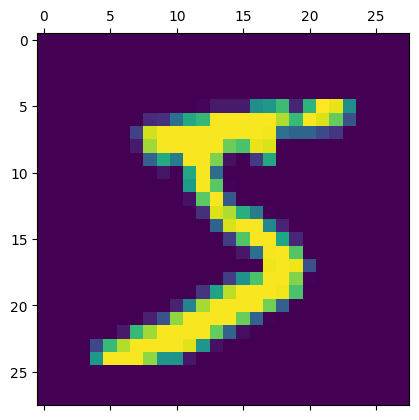

In [9]:
plt.matshow(X_train[0])
print('This digit is: ', Y_train[0])

**convert to float**
This model performs better when utilizing floating point computations, 
quantized model lead to a plateau in overall accuracy 

In [10]:
X_train = X_train/255
X_test = X_test/255

**reshape the training data and add an additional axis to modify shape (28, 28) -> (28, 28, 1)**

In [11]:
X_train = tf.expand_dims(X_train, axis=-1)

X_test = tf.expand_dims(X_test, axis=-1)

2023-12-18 15:53:18.395009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 15:53:18.423528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 15:53:18.423756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**Create the skeleton for the neural network model and configure the optimizer, and metrics**

In [12]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 10)                8

**Train the model**

In [13]:
with tf.device('/GPU:0'):
    history = model.fit(
                    X_train,
                    Y_train,
                    epochs=5,
                    batch_size=100
    )


Epoch 1/5


2023-12-18 15:53:19.655788: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-18 15:53:19.733082: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 15:53:19.919514: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f310a91b6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 15:53:19.919539: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-18 15:53:19.923977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-18 15:53:19.959313: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1702895000.003137  113089 devic

600/600 [==============================] - 3s 3ms/step - loss: 0.2862 - accuracy: 0.9173
Epoch 2/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0851 - accuracy: 0.9741
Epoch 3/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0625 - accuracy: 0.9810
Epoch 4/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0511 - accuracy: 0.9843
Epoch 5/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0449 - accuracy: 0.9861


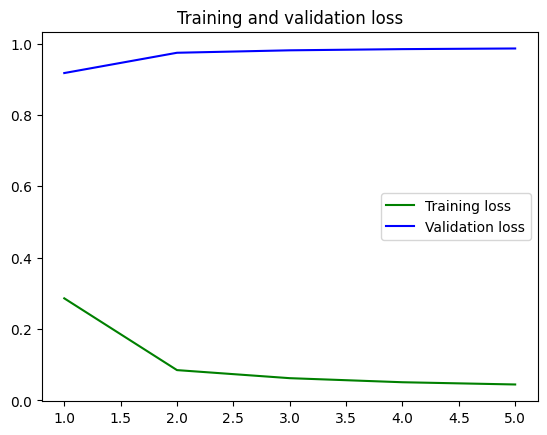

In [14]:
loss = history.history['loss']
val_loss = history.history['accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**collect a list of all the incorrect predictions**

In [15]:
predictions = model.predict(X_test)

idx = []

for i in range(len(Y_test)):
    if(Y_test[i] != np.argmax((predictions[i]))):
        idx.append(i)

# print the percent of correct predictions
print('test score: {}'.format(1 - (len(idx)/len(Y_test))))

313/313 [==============================] - 1s 1ms/step
test score: 0.9861


**Visualize one of the random errors made**

(28, 28)
Actual: 7, Predicted: 2


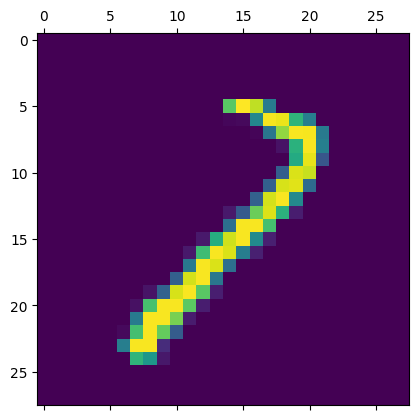

In [16]:
random_error = random.choice(idx)

print(X_test[random_error][:,:,0].shape)

plt.matshow(X_test[random_error][:,:,0])
print('Actual: {}, Predicted: {}'.format(Y_test[random_error], np.argmax((predictions[random_error]))))

**Convert and optimize it as a tflite model**

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpprncsigd/assets


INFO:tensorflow:Assets written to: /tmp/tmpprncsigd/assets
2023-12-18 15:53:30.313245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-18 15:53:30.313296: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-18 15:53:30.313677: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpprncsigd
2023-12-18 15:53:30.314482: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-18 15:53:30.314498: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpprncsigd
2023-12-18 15:53:30.316337: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-18 15:53:30.316898: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-18 15:53:30.346744: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

73136